# Permanent Magnet Synchrone Motor


In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score,mean_squared_error


from sklearn import svm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
#seaborn
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor



from sklearn import neighbors
from math import sqrt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

data/pmsm_temperature_data.csv


## read data


In [13]:

#df = pd.read_csv('data/pmsm_temperature_data.csv', 
#                 usecols=[0,1,2,3,4,5,6,7,8,9,10,11])

df = pd.read_csv('data/pmsm_temperature_data.csv')
#df = pd.read_csv('../input/pmsm_temperature_data.csv', 
 #                usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
df.head(10)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
5,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884,4
6,-0.749228,-1.116170,0.335014,-1.302082,-1.222430,-0.247914,1.030493,-0.246162,-2.522538,-1.833012,-2.062115,-2.017243,4
7,-0.738450,-1.113986,0.336256,-1.305155,-1.222432,-0.248321,1.030107,-0.246035,-2.522844,-1.832182,-2.061953,-2.017213,4
8,-0.730910,-1.111828,0.334905,-1.303790,-1.222432,-0.247785,1.029851,-0.245981,-2.522808,-1.831576,-2.062443,-2.017739,4
9,-0.727130,-1.109486,0.335988,-1.305633,-1.222431,-0.248294,1.029636,-0.245888,-2.522677,-1.831438,-2.062317,-2.018180,4


## data description


In [ ]:
df.info()


In [ ]:
df.describe().T


In [ ]:
df.isnull().values.any()


In [ ]:
nans=pd.isnull(df).sum()
nans[nans>0]

In [ ]:
df.dtypes.value_counts()

In [ ]:
df.corr()

In [14]:
import seaborn as sns
%matplotlib inline

#reduced_df = df.copy().drop(['profile_id', 'stator_yoke', 'stator_winding'], axis=1)
reduced_df = df.copy().drop(['profile_id'], axis=1)




In [ ]:
#sns.jointplot(x='i_d', y='motor_speed', data=df,  kind='reg')
#sns.pairplot(df.sample(1000))
sns.pairplot(reduced_df.sample(frac=0.01))

plt.show()

In [ ]:
reduced_df['coolant'].hist()

In [ ]:
# import pipeline
from sklearn.pipeline import Pipeline

# Preprocessing for categorical data
#data_transformer = Pipeline(steps=[
#    ('normalize_scale', MaxAbsScaler()),
#    ('transform', OneHotEncoder(handle_unknown='ignore'))
#])


In [15]:
# scale and normalization
# log normalization 
# coolant is long right tail 
#df['newCoolantlog'] = df.coolant.map(np.log)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
#ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
df2 = df.copy()

coolant = df2['coolant']
newCoolant = np.sign(coolant)*np.log(abs(coolant))
ss.fit(df2)
from pandas import DataFrame
df_scaled = DataFrame(ss.transform(df2), columns=df2.columns)
df_scaled['newCoolant'] = newCoolant

df_scaled_reduced = df_scaled.drop(['coolant', 'profile_id','stator_yoke', 'stator_winding'], axis=1)

# pca selection
from sklearn.decomposition import PCA
pca = PCA()
df_scaled_reduced_pca = DataFrame(pca.fit_transform(df_scaled_reduced), columns=df_scaled_reduced.columns )
print(pca.explained_variance_ratio_)

df_scaled_reduced_pca.describe().T

[4.21738269e-01 2.36679231e-01 1.49768451e-01 1.09557274e-01
 4.54609172e-02 1.84931461e-02 1.08392533e-02 4.06986187e-03
 3.31323802e-03 8.03582675e-05]


,count,mean,std,min,25%,50%,75%,max
ambient,998070.0,1.083043e-16,0.978643,-11.143828,-0.417176,0.135806,0.211758,11.812596
u_d,998070.0,1.565273e-15,0.733133,-1.378048,-0.732989,0.043904,0.637906,1.559858
u_q,998070.0,-6.528317e-16,0.583194,-1.442516,-0.358218,0.031437,0.373284,1.608646
motor_speed,998070.0,-2.036602e-16,0.498796,-1.458710,-0.370080,-0.009972,0.362722,1.540029
torque,998070.0,-6.948442e-16,0.321308,-0.951392,-0.223526,-0.027421,0.192220,1.483466
i_d,998070.0,2.123537e-16,0.204931,-0.620484,-0.130528,-0.019848,0.107780,1.401014
i_q,998070.0,7.726619e-18,0.156893,-0.794758,-0.090135,0.008617,0.090658,0.961521
pm,998070.0,1.936251e-16,0.096137,-0.443063,-0.064248,-0.003443,0.061409,0.700975
stator_tooth,998070.0,1.058007e-15,0.086742,-0.524885,-0.061256,-0.004519,0.050662,0.589239
newCoolant,998070.0,-5.507713e-17,0.013509,-0.295284,-0.005119,-0.000425,0.005324,0.383070


In [5]:
# plot scaled

sns.pairplot(df_scaled_reduced.sample(frac=0.01))
df_scaled_reduced.describe().T



,count,mean,std,min,25%,50%,75%,max
ambient,998070.0,-0.005856,0.041374,-0.488595,-0.012005,0.004365,0.011374,0.363236
u_d,998070.0,-0.006088,0.049866,-0.313609,-0.016908,0.004277,0.010873,0.303742
u_q,998070.0,0.004311,0.045798,-0.220529,-0.017425,-0.002149,0.018930,0.331669
motor_speed,998070.0,0.005372,0.057177,-0.207315,-0.016968,-0.003102,0.015959,0.400476
torque,998070.0,0.003249,0.039614,-0.336046,-0.008390,-0.003233,0.015186,0.366550
i_d,998070.0,-0.002017,0.053424,-0.385904,-0.014378,0.003762,0.015429,0.224160
i_q,998070.0,0.003207,0.039429,-0.289109,-0.008854,-0.003031,0.014631,0.354095
pm,998070.0,-0.005192,0.059395,-0.412899,-0.013545,0.001693,0.012294,0.438799
stator_tooth,998070.0,-0.010298,0.059370,-0.344790,-0.014938,0.000093,0.014256,0.206792
newCoolant,998070.0,0.117410,0.978041,-11.680643,-0.086492,-0.022846,0.538896,11.297204


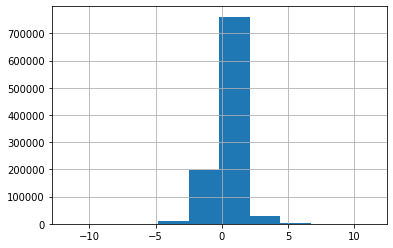

In [41]:
# new coolant scaled : log transformation from coolant
df_scaled_reduced['newCoolant'].hist( )



In [ ]:
#reduced_df = df.drop(['stator_yoke', 'stator_tooth', 'stator_winding'], axis=1)
matplotlib.rcParams.update({'font.size': 22})
g = sns.PairGrid(df_scaled_reduced.sample(frac=0.01))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

## correlation map

In [ ]:
#correlation map
f,ax=plt.subplots(figsize=(15,15))
matplotlib.rcParams.update({'font.size': 8})

corr=df.corr()

sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5},
            mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, ax=ax)



plt.show()

In [ ]:
# il faut ajouter une feature executionTime per profile
## pas necessaire car l'état de demarrage est aléatoire (le moteur peut ne pas commencer à froid lors d'une session)

In [16]:
X=df_scaled_reduced.drop(["pm" ,"torque", "stator_tooth"], axis=1)
y=df_scaled_reduced["pm"]

X2=reduced_df.drop(["pm" , "torque", 'stator_tooth'], axis=1)
y2=reduced_df["pm"]

X3=df_scaled_reduced_pca.drop(["pm" ,"torque", "stator_tooth"], axis=1)
y3=df_scaled_reduced_pca["pm"]


from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.2, random_state=42)
X3_train,X3_test,y3_train,y3_test=train_test_split(X3,y3,test_size=0.2, random_state=42)

training=df.copy()

In [11]:
import statsmodels.api as sm
lm=sm.OLS(y_train, X_train)

ols=lm.fit()
ols.summary() #All coefficients are significant for the model by looking at the p-value. ( P>|t| )
#print(model.pvalues)



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                          1.383e+06
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:26:39   Log-Likelihood:                      4.3805e+05
No. Observations:              798456   AIC:                                 -8.761e+05
Df Residuals:                  798449   BIC:                                 -8.760e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         0.9287      0.002    596.113      0.000       0.926       0.932
u_d            -0.1681      0.001   -177.064      0.000      -0.170      -0.166
u_q            -0.1424      0.001   -133.565      0.000      -0.145      -0.140
motor_speed     0.2121      0.001    162.564      0.000       0.210       0.215
i_d            -0.0479      0.001    -41.827      0.000      -0.050      -0.046
i_q            -0.2232      0.001   -184.983      0.000      -0.226      -0.221
newCoolant     -0.0160      0.000    -99.821      0.000      -0.016      -0.016
==============================================================================
Omnibus:                     1411.691   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1693.797
Skew:                          -0.033   Prob(JB):                         0.00
Kurtosis:                       3.216   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
import statsmodels.api as sm
lm2=sm.OLS(y2_train, X2_train)

ols2=lm2.fit()
ols2.summary()#All coefficients are significant for the model by looking at the p-value. ( P>|t| )


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.738
Model:                            OLS   Adj. R-squared (uncentered):              0.738
Method:                 Least Squares   F-statistic:                          2.505e+05
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:26:44   Log-Likelihood:                     -5.9403e+05
No. Observations:              798456   AIC:                                  1.188e+06
Df Residuals:                  798447   BIC:                                  1.188e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ambient            0.2546      0.001    378.108      0.000       0.253       0.256
coolant           -1.0336      0.003   -377.094      0.000      -1.039      -1.028
u_d               -0.0840      0.001    -76.837      0.000      -0.086      -0.082
u_q               -0.4199      0.001   -335.735      0.000      -0.422      -0.417
motor_speed        0.6203      0.002    331.187      0.000       0.617       0.624
i_d                0.3735      0.002    240.436      0.000       0.370       0.377
i_q               -0.0340      0.001    -30.764      0.000      -0.036      -0.032
stator_yoke        1.7018      0.005    349.024      0.000       1.692       1.711
stator_winding    -0.2630      0.003    -83.762      0.000      -0.269      -0.257
==============================================================================
Omnibus:                    26592.707   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75376.347
Skew:                           0.044   Prob(JB):                         0.00
Kurtosis:                       4.503   Cond. No.                         19.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
from sklearn.metrics import r2_score,mean_squared_error

olsRmseTrain=np.sqrt(mean_squared_error(y_train,ols.predict(X_train)))
olsRmseTrain

0.13979752505257964

In [15]:

ols2rmseTrain =np.sqrt(mean_squared_error(y2_train,ols2.predict(X2_train)))
ols2rmseTrain

0.5091735625423638

In [16]:
#Root Mean Squared Error for Test
olsRmseTest=np.sqrt(mean_squared_error(y_test,ols.predict(X_test)))
olsRmseTest

0.1397510463389044

In [12]:
ols2RmseTest=np.sqrt(mean_squared_error(y2_test,ols2.predict(X2_test)))
ols2RmseTest

0.5083553147870241

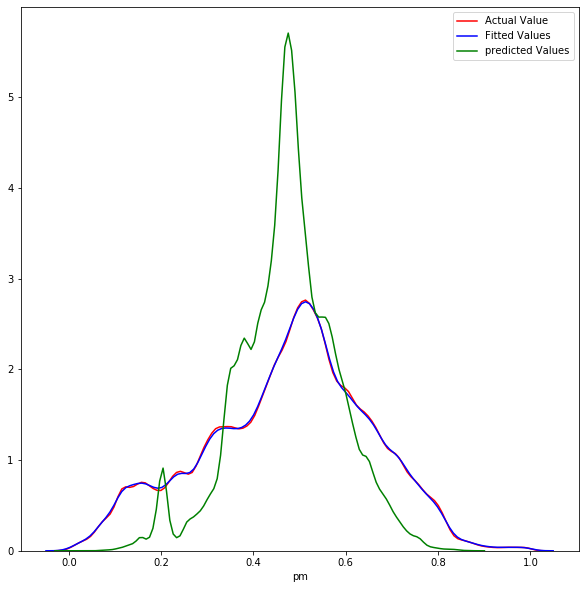

In [17]:
#Visualizing for Multiple Linear Regression y values model1

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(ols.predict(X_test), hist=False, color="g", label="predicted Values" , ax=ax1);



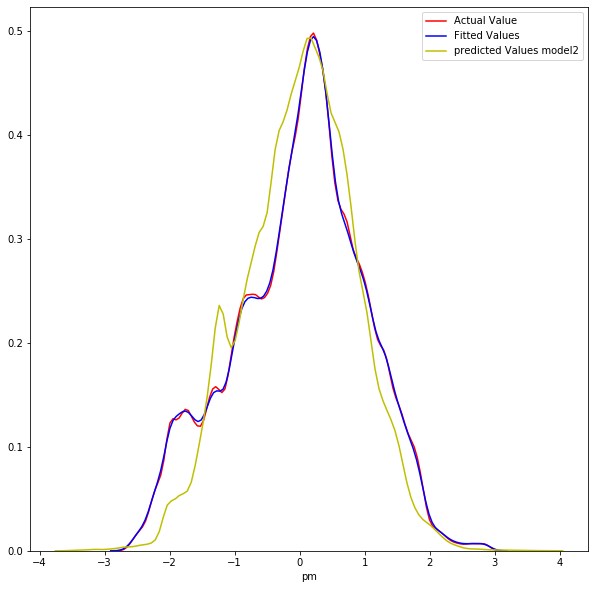

In [18]:
#Visualizing for Multiple Linear Regression y values

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y2_train, hist=False, color="r", label="Actual Value")
sns.distplot(y2_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(ols2.predict(X2_test), hist=False, color="y", label="predicted Values model2" , ax=ax1);

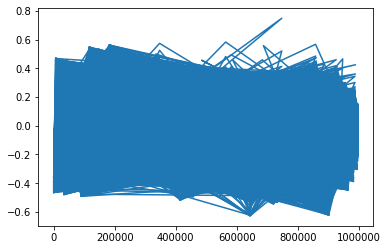

In [19]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols.resid)



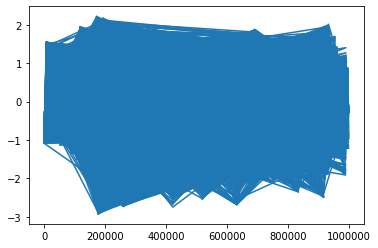

In [20]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols2.resid)

In [ ]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(ols, 0, ax=ax)
ax.set_ylabel("PM temp")
ax.set_xlabel("what")
ax.set_title("Linear Regression")
plt.show()

In [ ]:
sns.regplot(x="newCoolant", y=ols.predict(X_test), data=X_test);


In [ ]:
sns.regplot(x="u_d", y=ols.predict(X_test), data=X_test);


In [ ]:
sns.regplot(x="u_q", y=ols.predict(X_test), data=X_test);


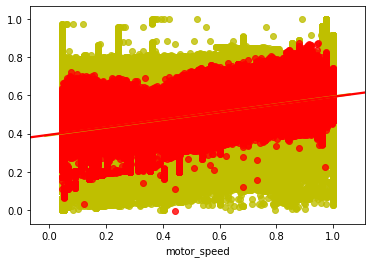

In [21]:
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
sns.regplot(x="motor_speed", y=ols.predict(X_test), label="predicted Value", color="r", data=X_test, ax=ax1);



In [ ]:
ax = sns.regplot(x="i_d", y=ols.predict(X_test), data=X_test);


In [ ]:
sns.regplot(x="i_q", y=ols.predict(X_test), data=X_test);


In [ ]:
 fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(ols, 0, ax=ax)
ax.set_ylabel("pm")

# KNN

In [17]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)


    #####could be done using GridSearchCV 
#from sklearn.model_selection import GridSearchCV
#params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

#knn = neighbors.KNeighborsRegressor()

#model = GridSearchCV(knn, params, cv=5)
#model.fit(x_train,y_train)
#model.best_params_

RMSE value for k=  1 is: 0.08819611077758731
RMSE value for k=  2 is: 0.08274162901283234
RMSE value for k=  3 is: 0.08317210794001714
RMSE value for k=  4 is: 0.08512792026830227
RMSE value for k=  5 is: 0.08727511090589825
RMSE value for k=  6 is: 0.08948659439062454
RMSE value for k=  7 is: 0.09141460787500888
RMSE value for k=  8 is: 0.09328105200516068
RMSE value for k=  9 is: 0.09502463928850914
RMSE value for k=  10 is: 0.0967122178145831
RMSE value for k=  11 is: 0.09823600705457833
RMSE value for k=  12 is: 0.09979609815910591
RMSE value for k=  13 is: 0.1011858702260528
RMSE value for k=  14 is: 0.10246416068296009
RMSE value for k=  15 is: 0.10375710761262542
RMSE value for k=  16 is: 0.10497160821989523
RMSE value for k=  17 is: 0.1060880098193906
RMSE value for k=  18 is: 0.10714490283281744
RMSE value for k=  19 is: 0.1081495729644277
RMSE value for k=  20 is: 0.10913885468899012


Text(0.5, 0, 'k')

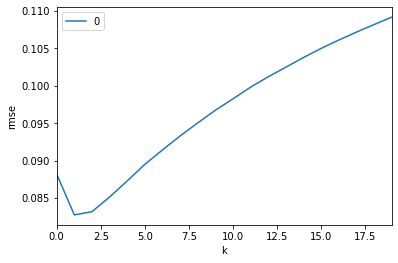

In [24]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
ax =curve.plot()
ax.set_ylabel("rmse")
ax.set_xlabel("k")

In [45]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X2_train, y2_train)  #fit the model
    pred=model.predict(X2_test) #make prediction on test set
    error = sqrt(mean_squared_error(y2_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.06417598984816705
RMSE value for k=  2 is: 0.06383316343640473
RMSE value for k=  3 is: 0.0686250159862264
RMSE value for k=  4 is: 0.07453878196296149
RMSE value for k=  5 is: 0.0800921844502174
RMSE value for k=  6 is: 0.0853500054939425
RMSE value for k=  7 is: 0.09018648117973233
RMSE value for k=  8 is: 0.09475995203773577
RMSE value for k=  9 is: 0.09911333045010262
RMSE value for k=  10 is: 0.10301337235507013
RMSE value for k=  11 is: 0.106762760660111
RMSE value for k=  12 is: 0.11032423702080271
RMSE value for k=  13 is: 0.11371568944380435
RMSE value for k=  14 is: 0.11698683539882317
RMSE value for k=  15 is: 0.12009441445120175
RMSE value for k=  16 is: 0.12287200390436474
RMSE value for k=  17 is: 0.12570513078438122
RMSE value for k=  18 is: 0.12830652728339845
RMSE value for k=  19 is: 0.1308928702160355
RMSE value for k=  20 is: 0.1333798741782733


In [19]:
knn_model_rs=KNeighborsRegressor(2).fit(X_train, y_train)
y_pred=knn_model_rs.predict(X_test)
y_pred.shape

(199614,)

In [20]:
knn_model=KNeighborsRegressor(2).fit(X2_train, y2_train)
y2_pred=knn_model.predict(X2_test)
y2_pred.shape

(199614,)

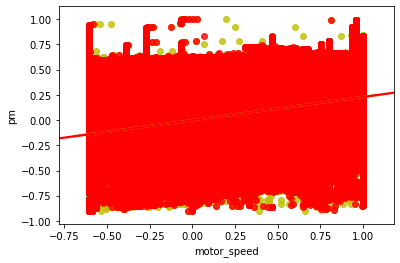

In [21]:
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
sns.regplot(x="motor_speed", y=y_pred, label="predicted Value", color="r", data=X_test, ax=ax1);

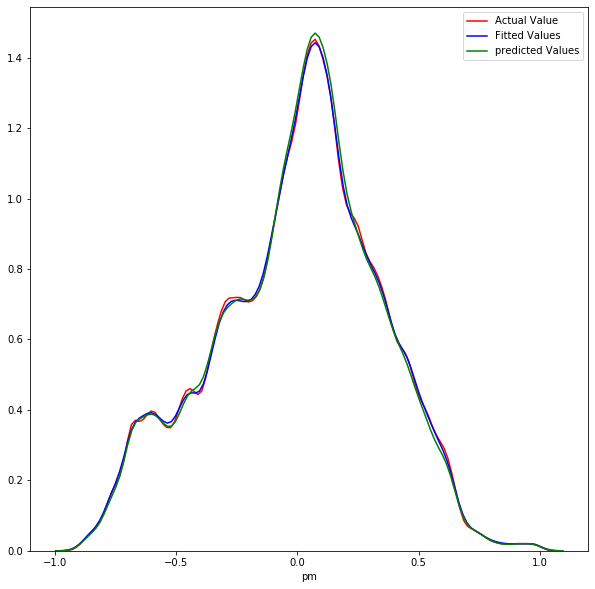

In [22]:

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(y_pred, hist=False, color="g", label="predicted Values" , ax=ax1);